This notebook justifies the assumptions used in simulation in dfcbenchmarker (mainly simulation 2 and 3). It is the code for the supplementary material of that paper.

How this is done is to first download the midnight scanning club data from openfmri.

It then uses the already preprocessed data and finds the range of the autocorrelation and crosscorrelation between the parcell

The aim is to do the following:

1. Find the distribution of autocorrelation in the dataset
2. Find the distribution of cross correlation in the dataset
3. Plot the time series distributions.
4. Static connectivity distributions

It assumes that the data is already downloaded. If you havn't it can be downloaded here with fetchopenfmri (github.com/wiheto/fetchopenfmri):

```
pip install fetchopenfmri
```

```
fetchopenfmri 224 <path> 1
```

where <path> is where the data should be saved.

The cifti files have different lengths to the surface_parcellation. The cifti files only have a network parition (in cifit_networks).
This results in having to make large correlation matrices which are inefficient for the cross-correlations here.
As the mapping from cifti files to surface_parcellation is unclear, I used the TAL volumetric data. I then made 5mm
ROI spheres based on Shen et al Neuroimage 2013 paper which has the center of mass in TAL corrdinates
for each ROI. Can be downloaded here: https://www.nitrc.org/frs/shownotes.php?release_id=2340
After this the headline of "Group_seg150_BAindexing_setA" must have commas after each of the headers.
So it reads "subunnit,    name,     Talairach X,   Talairach Y,   Talairach Z"

import necessary packages

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import scipy.stats as stats
from bids.grabbids import BIDSLayout
import numpy as np
import pandas as pd
from nilearn import input_data
import os

Specify some parameters for where the data is

In [2]:
dataset_path = '/media/william/04155B0D1212FC05/openfmri/ds000224_R1.0.0/'
template_path = '/media/william/04155B0D1212FC05/parcellations/shenetal_neuroimage2013/'

Define some funcitons that will be needed:
autocorrelation, crosscorrelation

In [3]:
def autocorr(x,lags=10):
    xr = np.zeros(lags+1)
    xr[0] = stats.pearsonr(x,x)[0]
    xr[1:lags+1] = [stats.pearsonr(x[l:],x[:-l])[0] for l in range(1,lags+1)]
    return xr

def crosscorr(x,y,lags=10):
    xr = np.zeros(lags+1)
    xr[0] = stats.pearsonr(x,y)[0]
    xr[1:lags+1] = [stats.pearsonr(x[l:],y[:-l])[0] for l in range(1,lags+1)]
    return xr


def cifti_to_pd(dataset_path,sub,ses):
    # loads the preprocessed cifti data and returns it as a pandas dataframe with rows = time, columns = space
    file_path = dataset_path + '/' + 'derivatives' + '/' + 'sub-' + sub + '/processed_restingstate_timecourses/ses-' + ses + '/cifti/'
    file_name = 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_32k_fsLR_v2.dtseries.nii'
    parcellation_path = '/media/william/04155B0D1212FC05/openfmri/ds000224_R1.0.0/derivatives/' + 'sub-' + sub + '/surface_parcellation/'
    parcellation_file = 'sub-' + sub + '_parcels.dtseries.nii'
    network_file = 'sub-' + sub + '_parcel_networks.dscalar.nii'
    cifti = nib.load(file_path + file_name)
    parc = nib.load(parcellation_path + parcellation_file)
    net = nib.load(parcellation_path + network_file)
    data = np.squeeze(cifti.get_data())
    df = pd.DataFrame(data)
    return df


# Cifti are currently cifti 1 files, so make cifti 2
def convert_cifti_to_cifti2(dataset_path,sub,ses):
    file_path = dataset_path + '/' + 'derivatives' + '/' + 'sub-' + sub + '/processed_restingstate_timecourses/ses-' + ses + '/cifti/'
    file_name = 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_32k_fsLR.dtseries.nii'
    file_name_out = 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_32k_fsLR_v2.dtseries.nii'
    os.system('wb_command -file-convert -cifti-version-convert ' + file_path + file_name + ' 2 ' + file_path + file_name_out)

def tal_to_pd(dataset_path,template_path,sub,ses):
    # loads the preprocessed talaraich data and returns it as a pandas dataframe with rows = time, columns = space
    file_path = dataset_path + '/' + 'derivatives' + '/' + 'sub-' + sub + '/processed_restingstate_timecourses/ses-' + ses + '/talaraich/'
    file_name = 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_talaraich.nii.gz'

    tal = load_shen_2013(template_path)
    seed = input_data.NiftiSpheresMasker(np.array(tal),5)
    data = seed.fit_transform(file_path + file_name)
    # if any roi is dropped
    if np.sum(np.std(data,axis=0)==0)>0:
        col = np.where(np.std(data,axis=0)==0)[0]
        data = np.delete(data,col,1)
        print(str(len(col)) + 'roi(s) dropped for: sub-' + str(sub) + ', ses-' + str(ses))

    df = pd.DataFrame(data)
    df.to_csv(file_path + 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_shenROI.csv')


def load_shen_2013(template_path,dataset_version='150'):
    tal = pd.read_csv(template_path + '/Group_seg'+ str(dataset_version) + '_BAindexing_setA.txt',delimiter=',',skipinitialspace=True)
    #Remove any trailing whitespaces
    tal.columns=tal.columns.str.rstrip()
    tal = tal[['Talairach X','Talairach Y','Talairach Z']]
    return tal

Loop through each subject and session, convert cifti to cifti-2 for nibabel.

(This is not used now, so commented out)

In [4]:
#layout = BIDSLayout(dataset_path)
#subjects = layout.get_subjects()
#sessions = layout.get_sessions(type='bold')
#[convert_cifti_to_cifti2(dataset_path,sub,ses) for sub in subjects for ses in sessions[:10]]

#parcels = '/media/william/04155B0D1212FC05/openfmri/ds000224_R1.0.0/derivatives/sub-MSC02/surface_parcellation/sub-MSC02_parcels.dtseries.nii'

Loop through each subject and session, save data as ROIs

In [5]:
layout = BIDSLayout(dataset_path)
subjects = layout.get_subjects()
sessions = layout.get_sessions(type='bold')
for sub in subjects:
    print(sub)
    # Even if there are more than 10 rest sessions in BIDs, only 10 in preprocessing
    for ses in sessions[:10]:
        tal_to_pd(dataset_path,template_path,sub,ses)

MSC01
MSC02
1roi(s) dropped for: sub-MSC02, ses-func07
MSC03
MSC04
MSC05
MSC06
MSC07
MSC08
MSC09
MSC10


Warning messages from the above: 1roi(s) dropped for: sub-MSC02, ses-func07

Loop through each subjects and calculate the autocorrelation

In [6]:
# Preallocate the information that will be collected per session

autocorr_avg = []
autocorr_std = []
autocorr_min = []
autocorr_max = []
autocorr_n = []
autocorr_sub = []
autocorr_ses = []


for sub in subjects:
    print(sub)
    # Even if there are more than 10 rest sessions in BIDs, only 10 in preprocessing
    for ses in sessions[:10]:
        file_path = dataset_path + '/' + 'derivatives' + '/' + 'sub-' + sub + '/processed_restingstate_timecourses/ses-' + ses + '/talaraich/'
        df = pd.read_csv(file_path + 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_shenROI.csv',index_col='Unnamed: 0')

        autocorrelation = np.array([autocorr(df[ts]) for ts in df.columns])

        autocorr_avg.append(np.mean(autocorrelation,axis=0))
        autocorr_std.append(np.std(autocorrelation,axis=0))
        autocorr_min.append(np.min(autocorrelation,axis=0))
        autocorr_max.append(np.max(autocorrelation,axis=0))
        autocorr_n.append(autocorrelation.shape[0])
        autocorr_sub.append(sub)
        autocorr_ses.append(ses)

autocorr_df = pd.DataFrame(data={'avg':autocorr_avg,'std':autocorr_std,'min':autocorr_min,'max':autocorr_max,'n':autocorr_n,'sub':autocorr_sub,'ses':autocorr_ses})

#Save df
autocorr_df.to_pickle('./autocorr_df.pkl')

MSC01
MSC02
MSC03
MSC04
MSC05
MSC06
MSC07
MSC08
MSC09
MSC10


Loop through each subjects and calculate the crosscorrelation

In [7]:
# Preallocate the information that will be collected per session

crosscorr_avg = []
crosscorr_std = []
crosscorr_min = []
crosscorr_max = []
crosscorr_bin = []
crosscorr_sub = []
crosscorr_ses = []



for sub in subjects:
    print(sub)
    # Even if there are more than 10 rest sessions in BIDs, only 10 in preprocessing
    for ses in sessions[:10]:
        file_path = dataset_path + '/' + 'derivatives' + '/' + 'sub-' + sub + '/processed_restingstate_timecourses/ses-' + ses + '/talaraich/'
        df = pd.read_csv(file_path + 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_shenROI.csv',index_col='Unnamed: 0')

        ind=np.triu_indices(len(df.columns),k=1)

        # Static connectivity
        r = np.array(df.corr())[ind[0],ind[1]]
        r = np.around(r,1)
        r_bins = np.unique(r)


        crosscorrelation = np.array([crosscorr(df[str(ind[0][n])],df[str(ind[1][n])]) for n in np.arange(0,len(ind[0]))])

        cc_df = pd.DataFrame(crosscorrelation)
        cc_df['bin'] = r
        gcc_df = cc_df.groupby('bin')

        [crosscorr_avg.append(gcc_df.mean().loc[b].values) for b in r_bins]
        [crosscorr_std.append(gcc_df.std().loc[b].values) for b in r_bins]
        [crosscorr_min.append(gcc_df.min().loc[b].values) for b in r_bins]
        [crosscorr_max.append(gcc_df.max().loc[b].values) for b in r_bins]
        [crosscorr_bin.append(b) for b in r_bins]
        [crosscorr_sub.append(sub) for b in r_bins]
        [crosscorr_ses.append(ses) for b in r_bins]


crosscorr_df = pd.DataFrame(data={'avg':crosscorr_avg,'std':crosscorr_std,'min':crosscorr_min,'max':crosscorr_max,'bin':crosscorr_bin,'sub':crosscorr_sub,'ses':crosscorr_ses})

#Save df
crosscorr_df.to_pickle('./crosscorr_df.pkl')

MSC01
MSC02
MSC03
MSC04
MSC05
MSC06
MSC07
MSC08
MSC09
MSC10


Plot autocorrelation:

1. example subject for entire 10 lags
2. all subjects at lag = 1

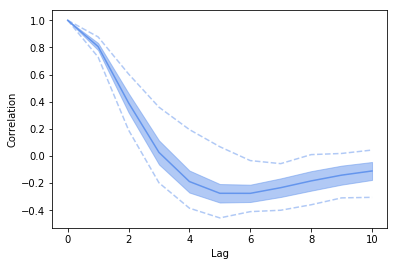

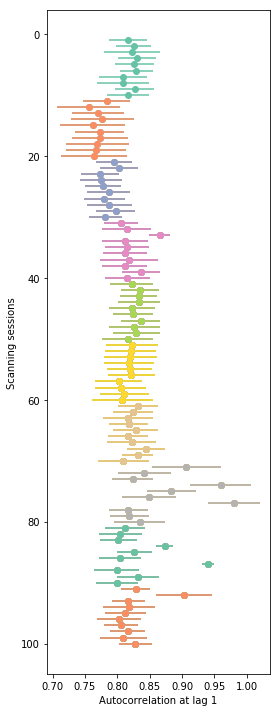

In [8]:
## Load data
autocorr_df = pd.read_pickle('autocorr_df.pkl')


# Plot 1

# Take randomly chosen example to show
np.random.seed(2017)
subind,sesind = np.random.randint(0,10,2)
sub = subjects[subind]
ses = sessions[sesind]

# Get avg, std, min and max for above subject/session
avg = autocorr_df['avg'][autocorr_df['sub']==sub][autocorr_df['ses']==ses].values[0]
std = autocorr_df['std'][autocorr_df['sub']==sub][autocorr_df['ses']==ses].values[0]
mints = autocorr_df['min'][autocorr_df['sub']==sub][autocorr_df['ses']==ses].values[0]
maxts = autocorr_df['max'][autocorr_df['sub']==sub][autocorr_df['ses']==ses].values[0]

# Plot figure
fig, ax = plt.subplots(1)
ax.plot(np.arange(0,11),avg,color='cornflowerblue')
ax.plot(np.arange(0,11),mints,'--',color='cornflowerblue',alpha=0.5)
ax.plot(np.arange(0,11),maxts,'--',color='cornflowerblue',alpha=0.5)
ax.fill_between(np.arange(0,11), avg-std, avg+std,color='cornflowerblue',alpha=0.5)
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation')

# Save
fig.savefig('./figures/autocorr_example-subject_lag1-10.pdf',dpi=300)

# Plot 2

# Get discrete colormap
# Note as there are only 8 colours in Set (and few discrete colormaps with 10 values (those that do have a hard to see yellow))
# This means we will have to loop back to the start of the colormap
gen_cmap = plt.cm.get_cmap('Set2')
col=mcolors.LinearSegmentedColormap.from_list(gen_cmap.name, gen_cmap(np.linspace(0, 1, 8)),8)

# Get the avg and std of all subjects at lag 1
avg = np.vstack(autocorr_df['avg'])[:,1]
std = np.vstack(autocorr_df['std'])[:,1]
# Make a y index
ses = np.arange(1,101)

# Color index
i=0

# ax.scatter(avg,ses,color='cornflowerblue')
fig, ax = plt.subplots(1,figsize=(4,10))
# Loop over each subject
for n in np.arange(0,100,10):
    #reset color index when it reaches 8
    if i==8:
        i=0
    ax.errorbar(avg[n:], ses[n:], xerr=std[n:],fmt='o',color=col(i))
    i+=1
ax.set_ylabel('Scanning sessions')
ax.set_xlabel('Autocorrelation at lag 1')
plt.gca().invert_yaxis()
plt.tight_layout()
# Save fig
fig.savefig('./figures/autocorr_allsubjects_lag1.pdf',dpi=300)

Plot crosscorrelation:

1. example subject for entire 10 lags
2. example subject distributions
3. all subjects at lag = 1

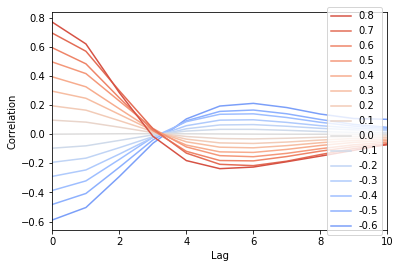

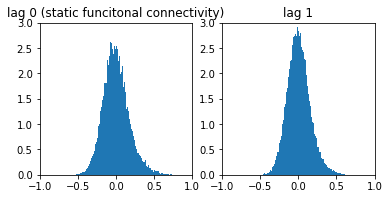

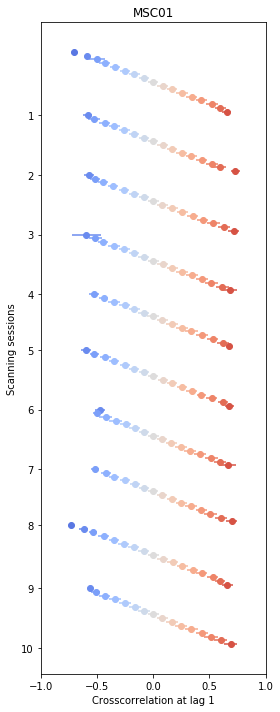

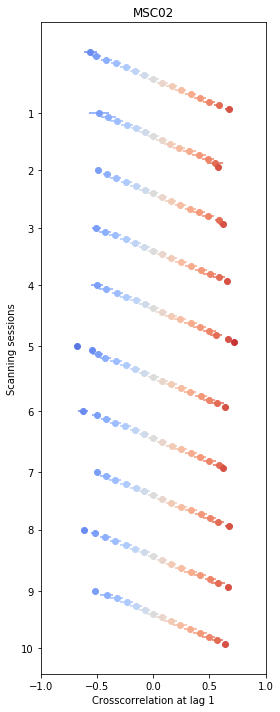

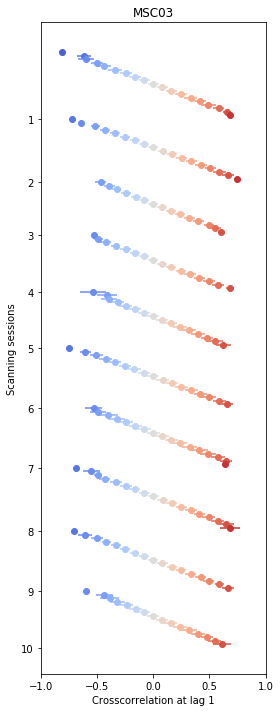

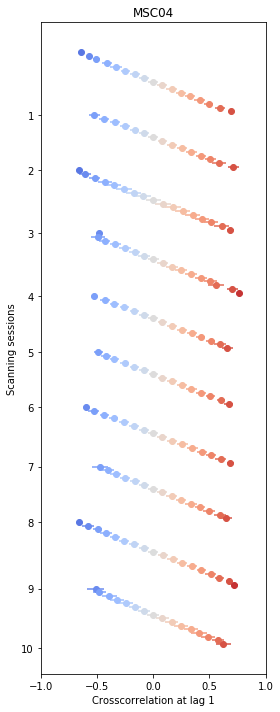

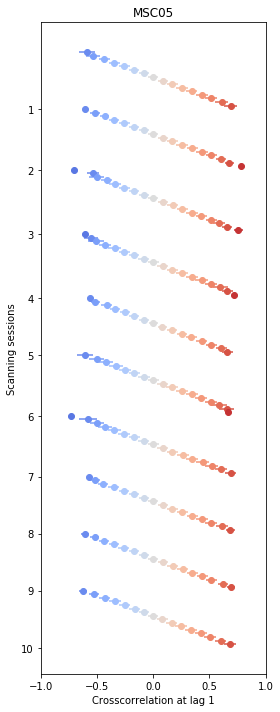

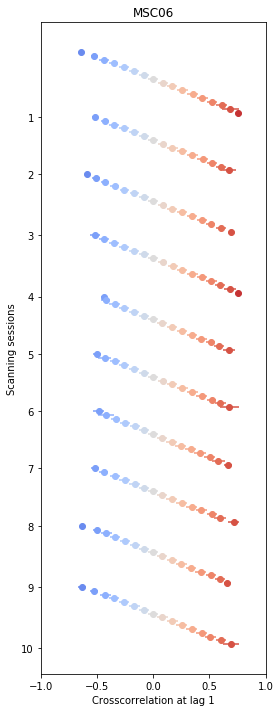

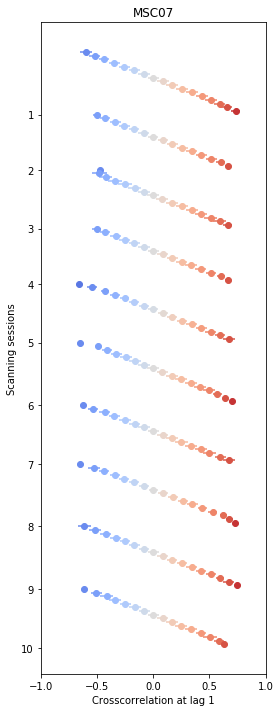

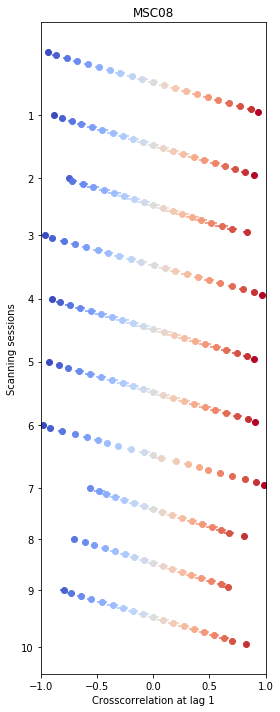

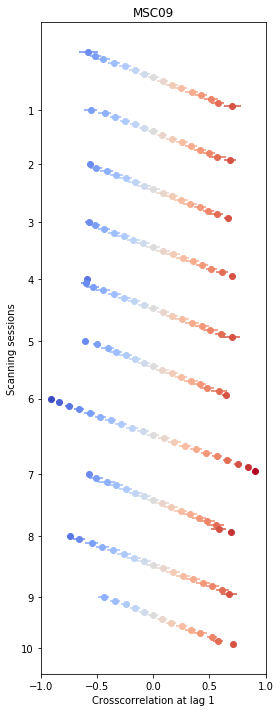

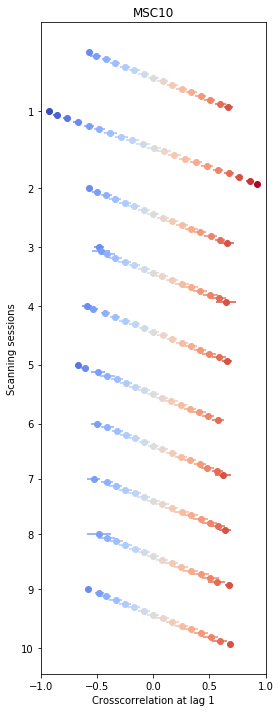

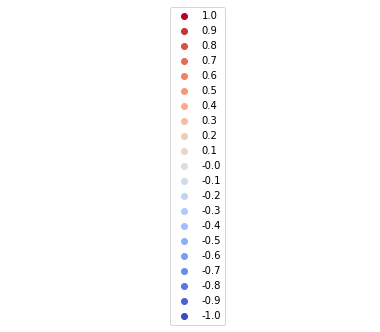

In [9]:
## Load data
crosscorr_df = pd.read_pickle('crosscorr_df.pkl')

# Plot 1

# Take randomly chosen example to show
np.random.seed(2017)
subind,sesind = np.random.randint(0,10,2)
sub = subjects[subind]
ses = sessions[sesind]

bin_vals = np.unique(crosscorr_df['bin'][crosscorr_df['sub']==sub][crosscorr_df['ses']==ses])
colors = [plt.cm.coolwarm(x) for x in np.linspace(((bin_vals+1)/2).min(), ((bin_vals+1)/2).max(), len(bin_vals)) ]

fig, ax = plt.subplots(1)
lines = []
for i,statcorr_bin in enumerate(bin_vals):

    # Get avg, std, min and max for above subject/session
    avg = crosscorr_df['avg'][crosscorr_df['sub']==sub][crosscorr_df['ses']==ses][crosscorr_df['bin']==statcorr_bin].values[0]
    std = crosscorr_df['std'][crosscorr_df['sub']==sub][crosscorr_df['ses']==ses][crosscorr_df['bin']==statcorr_bin].values[0]
    mints = crosscorr_df['min'][crosscorr_df['sub']==sub][crosscorr_df['ses']==ses][crosscorr_df['bin']==statcorr_bin].values[0]
    maxts = crosscorr_df['max'][crosscorr_df['sub']==sub][crosscorr_df['ses']==ses][crosscorr_df['bin']==statcorr_bin].values[0]

    # Plot figure
    lax = ax.plot(np.arange(0,11),avg,color=colors[i],label=statcorr_bin)
    lines.append(lax)
    #ax.plot(np.arange(0,11),mints,'--',color='cornflowerblue',alpha=0.5)
    #ax.plot(np.arange(0,11),maxts,'--',color='cornflowerblue',alpha=0.5)
    #ax.fill_between(np.arange(0,11), avg-std, avg+std,color='cornflowerblue',alpha=0.5)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation')

ax.set_xlim(0,10)
handles,labels = ax.get_legend_handles_labels()
ax.legend(np.flipud(handles), np.flipud(labels),loc='right')

fig.savefig('./figures/crosscorr_example-subject_lag1-10.pdf',dpi=300)

## Plot 2 - distribution of edges for example subject at lag 0 and lag 1

file_path = dataset_path + '/' + 'derivatives' + '/' + 'sub-' + sub + '/processed_restingstate_timecourses/ses-' + ses + '/talaraich/'
df = pd.read_csv(file_path + 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_shenROI.csv',index_col='Unnamed: 0')
ind=np.triu_indices(len(df.columns),k=1)
crosscorrelation = np.array([crosscorr(df[str(ind[0][n])],df[str(ind[1][n])],lags=1) for n in np.arange(0,len(ind[0]))])
lag0 = crosscorrelation[:,0]
lag1 = crosscorrelation[:,1]

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.hist(lag0,bins=np.arange(-1,1,0.01),normed=True)
ax2.hist(lag1,bins=np.arange(-1,1,0.01),normed=True)
ax1.set_ylim(max([ax1.axes.get_ylim(),ax2.axes.get_ylim()]))
ax2.set_ylim(max([ax1.axes.get_ylim(),ax2.axes.get_ylim()]))
ax1.set_xlim(-1,1)
ax2.set_xlim(-1,1)
ax1.set_ylim(0,3)
ax2.set_ylim(0,3)
def square_axis(ax):
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    return ax
ax1 = square_axis(ax1)
ax2 = square_axis(ax2)
ax1.set_title('lag 0 (static funcitonal connectivity)')
ax2.set_title('lag 1')
# Save
fig.savefig('./figures/crosscorr_distribution_of_edges_lag0_and_lag1.pdf',dpi=300)

# Plot 3

# Get discrete colormap
# Note as there are only 8 colours in Set (and few discrete colormaps with 10 values (those that do have a hard to see yellow))
# This means we will have to loop back to the start of the colormap



for i,sub in enumerate(np.unique(crosscorr_df['sub'])):

    fig, ax = plt.subplots(1,figsize=(4,10))
    ytick = []
    ii=0
    for j,ses in enumerate(np.unique(crosscorr_df['ses'])):

        bin_vals = np.unique(crosscorr_df['bin'][crosscorr_df['sub']==sub][crosscorr_df['ses']==ses])
        colors = np.array([plt.cm.coolwarm(x) for x in np.linspace(((bin_vals+1)/2).min(), ((bin_vals+1)/2).max(), len(bin_vals)) ])
        avg = []
        std = []
        color_plot = []

        for statcorr_bin in bin_vals:

            # Get the avg and std of all subjects at lag 1
            avg.append(np.vstack(crosscorr_df['avg'][crosscorr_df['sub']==sub][crosscorr_df['ses']==ses][crosscorr_df['bin']==statcorr_bin])[:,1])
            std.append(np.vstack(crosscorr_df['std'][crosscorr_df['sub']==sub][crosscorr_df['ses']==ses][crosscorr_df['bin']==statcorr_bin])[:,1])

        avg = np.concatenate(avg)
        std = np.concatenate(std)
        std[np.isnan(std)]=0
        #reset color index when it reaches 8
        [ax.errorbar(avg[a], ii+a, xerr=std[a],fmt='o',c=colors[a]) for a in np.arange(0,len(avg))]
        ii+=len(avg)
        ytick.append(ii)

    ax.set_xlim(-1,1)
    ax.set_yticks(ytick)
    ax.set_yticklabels(np.arange(1,11))
    ax.set_title(sub)
    plt.gca().invert_yaxis()
    ax.set_ylabel('Scanning sessions')
    ax.set_xlabel('Crosscorrelation at lag 1')
    plt.tight_layout()
    # Save fig
    fig.savefig('./figures/crosscorr_allsubjects_lag1_' + sub + '.pdf',dpi=300)

# Create colour legend for crosscorr_allsubjects_lag1

bin_vals = np.arange(-1,1.1,0.1)
colors = np.array([plt.cm.coolwarm(x) for x in np.linspace(((bin_vals+1)/2).min(), ((bin_vals+1)/2).max(), len(bin_vals)) ])
fig,ax = plt.subplots(1)
[ax.scatter(0,0,color=c,label=np.around(bin_vals[i],1)) for i,c in enumerate(colors)]
ax.set_xlim(1,2)
ax.set_ylim(1,2)
handles,labels = ax.get_legend_handles_labels()
ax.legend(np.flipud(handles), np.flipud(labels),loc='center')
plt.axis('off')
fig.savefig('./figures/crosscorr_allsubjects_lag1_legend.pdf',dpi=300)

Random example is: sub:MSC10ses:func07


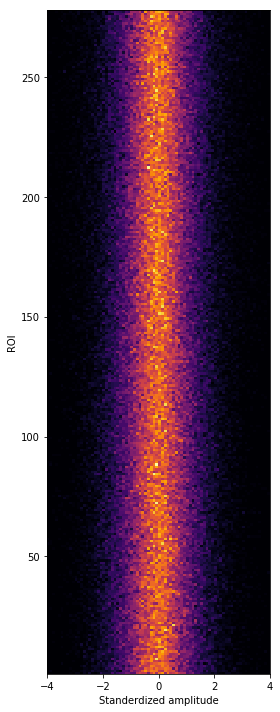

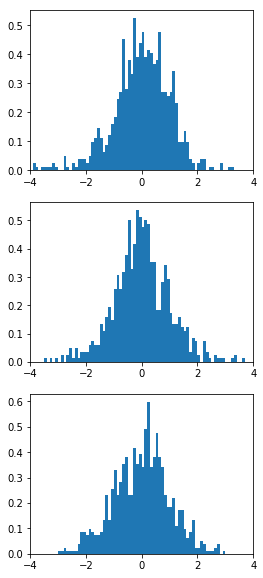

In [10]:
"""
Finally there is also a Gaussian assumption, that each time series is samples from a Gaussian distribution.
"""

# Take randomly chosen example to show
np.random.seed(2017)
subind,sesind = np.random.randint(0,10,2)
sub = subjects[subind]
ses = sessions[sesind]

print('Random example is: sub:' + str(sub) + 'ses:' + str(ses))

file_path = dataset_path + '/' + 'derivatives' + '/' + 'sub-' + sub + '/processed_restingstate_timecourses/ses-' + ses + '/talaraich/'
df = pd.read_csv(file_path + 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_shenROI.csv',index_col='Unnamed: 0')

df_scaled = (df - df.mean()) / (df.std())
x_bins = np.arange(np.floor(df_scaled.min().min()),np.ceil(df_scaled.max().max()),0.1)
hist = [np.histogram(df_scaled[c],bins=x_bins)[0] for c in df_scaled.columns]
hist = np.vstack(hist)
hist_sort = hist[np.argsort(np.median(hist,axis=1)),:]

fig,ax = plt.subplots(1,figsize=(4,10))
ax.pcolormesh(x_bins,np.arange(0,len(hist_sort))+1,hist_sort,cmap='inferno',rasterized=True)
# Note some outliers removed
ax.set_xlim(-4,4)
ax.set_ylabel('ROI')
ax.set_xlabel('Standerdized amplitude')
plt.tight_layout()
fig.savefig('./figures/gaussian_assumption_example_subject.pdf',dpi=300)

# Example distribution
x_bins = np.arange(-4,4.01,0.1)
fig,ax = plt.subplots(3,figsize=(4,10))
r = np.random.randint(0,len(hist_sort),3)
[ax[i].hist(df_scaled[str(r[i])],bins=x_bins,normed=1) for i in np.arange(0,3)]
[ax[i].set_xlim(-4,4) for i in np.arange(0,3)]
fig.savefig('./figures/gaussian_assumption_example_subject_3rois.pdf',dpi=300)

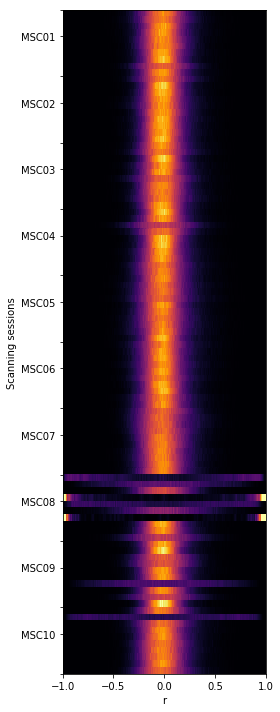

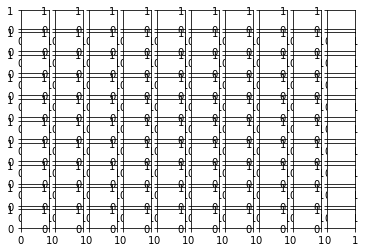

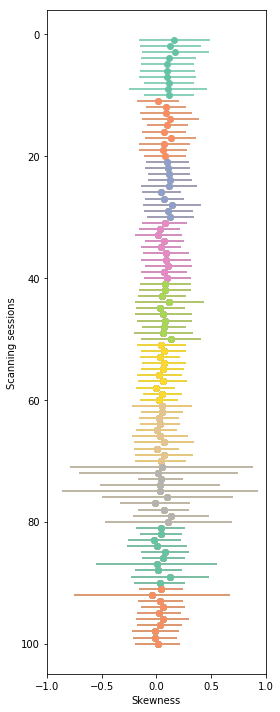

In [11]:
"""
Plot static connectivity distribution per subject
"""

r_hist = []

for i,sub in enumerate(subjects):
    for j,ses in enumerate(sessions[:10]):
        file_path = dataset_path + '/' + 'derivatives' + '/' + 'sub-' + sub + '/processed_restingstate_timecourses/ses-' + ses + '/talaraich/'
        df = pd.read_csv(file_path + 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_shenROI.csv',index_col='Unnamed: 0')
        ind = np.triu_indices(len(df.columns), k=1)
        r = np.array(df.corr())[ind[0], ind[1]]
        r_hist.append(np.histogram(r, bins=np.arange(-1,1.001,0.01), normed=True)[0])

bin_edges = np.arange(-1, 1.001, 0.01)
bins = (bin_edges[:-1] + bin_edges[1:]) / 2
r_hist = np.vstack(r_hist)

fig, ax = plt.subplots(figsize=(4,10))

# Set manual vmax due to MSC08 outlier
ax.pcolormesh(bin_edges,np.arange(0.5,101.5),r_hist,cmap='inferno',rasterized=True,vmax=3.5)
ax.set_ylabel('Scanning sessions')
ax.set_xlabel('r')
ax.set_xlim(-1,1)
ax.set_yticks(np.hstack([np.arange(4.5,101,10), np.arange(0.5,101,10)]))
ax.set_yticklabels(subjects)
plt.gca().invert_yaxis()
plt.tight_layout()
fig.savefig('./figures/static_connectivity.pdf',dpi=300)




"""
Get the skewness of the distributions per subject and session.
"""

fig,ax = plt.subplots(10,10)

mean_sk = []
std_sk = []

for i,sub in enumerate(subjects):
    for j,ses in enumerate(sessions[:10]):
        file_path = dataset_path + '/' + 'derivatives' + '/' + 'sub-' + sub + '/processed_restingstate_timecourses/ses-' + ses + '/talaraich/'
        df = pd.read_csv(file_path + 'sub-' + sub + '_ses-' + ses +  '_task-rest_bold_shenROI.csv',index_col='Unnamed: 0')
        sk=stats.skew(df)
        mean_sk.append(np.mean(sk))
        std_sk.append(np.std(sk))


# Get discrete colormap
# Note as there are only 8 colours in Set (and few discrete colormaps with 10 values (those that do have a hard to see yellow))
# This means we will have to loop back to the start of the colormap
gen_cmap = plt.cm.get_cmap('Set2')
col=mcolors.LinearSegmentedColormap.from_list(gen_cmap.name, gen_cmap(np.linspace(0, 1, 8)),8)

# Make a y index
ses = np.arange(1,101)

# Color index
i=0

# ax.scatter(avg,ses,color='cornflowerblue')
fig, ax = plt.subplots(1,figsize=(4,10))
# Loop over each subject
for n in np.arange(0,100,10):
    #reset color index when it reaches 8
    if i==8:
        i=0
    ax.errorbar(mean_sk[n:], ses[n:], xerr=std_sk[n:],fmt='o',color=col(i))
    i+=1

ax.set_ylabel('Scanning sessions')
ax.set_xlabel('Skewness')
ax.set_xlim(-1,1)
plt.gca().invert_yaxis()
plt.tight_layout()
fig.savefig('./figures/skewness.pdf',dpi=300)